In [62]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import glob, os
import statistics as stats

### Load files 

This cell loads all files *in the current working directory* starting with `tmp.` - it would be more convenient to name the output files this way.

In [ ]:
#load all files and read every 5th line starting from line 5
#line numbering starts from 0
filenames = glob.glob('./tmp.*')
mfrs = []

for file in filenames:
    #read lines
    with open(file) as f:
        lines = f.readlines()
    desired_lines = lines[5::5]
    
    #split text to get mass flow rate
    for count, line in enumerate(desired_lines):
        desired_lines[count] = float(line.split()[-1])
        
    #append mass flow rates to list
    mfrs.append(desired_lines)
    
#convert to numpy array - multiply by nominal channel width
#this includes those with varying channel width - effectively a comparison in mass flow rate per unit width
#normalised by nominal width
mfrs = np.array(mfrs)*0.4*1e-2              

### Time series averaging

Each set of data is a time series of mass flow rates. We assume independence of these mass flow rates with each other and compute the means and variances as usual - this gives, effectively, a number of independently but identically distributed sample of mass flow rates for subsequent analysis.

In [64]:
#calculate mean and variance for each file
mfr_mu = np.zeros(len(filenames))
mfr_var = np.zeros(len(filenames))

for i, file in enumerate(filenames):
    mfr_mu[i] = stats.mean(mfrs[i,:])
    mfr_var[i] = stats.variance(mfrs[i,:])
    
    if (file == './tmp.outflux'):
        mfr_nom = mfr_mu[i]
        var_nom = mfr_var[i]
    
#print results
#checking the indices corresponding to each file
#T for temp, A for alpha, H for height, outflux nominal
print(filenames)
print(mfr_mu)
print(np.sqrt(mfr_var))

dim = np.shape(mfrs)[1]

['./tmp.outH4005', './tmp.outA080', './tmp.outT428', './tmp.outA098', './tmp.outH401', './tmp.outA099', './tmp.outT422', './tmp.outT420', './tmp.outH3995', './tmp.outH420', './tmp.outA090', './tmp.outH350', './tmp.outflux', './tmp.outT424']
[7.36936240e-06 7.69805840e-06 7.41114016e-06 7.39944996e-06
 7.37107356e-06 7.38229700e-06 7.35719460e-06 7.34002060e-06
 7.36360000e-06 7.45255512e-06 7.52986780e-06 7.09083892e-06
 7.36624320e-06 7.37447288e-06]
[7.75357745e-08 7.84235980e-08 7.67032010e-08 7.62786901e-08
 7.70941552e-08 7.95932651e-08 7.41837579e-08 7.88557709e-08
 7.84869704e-08 7.75719520e-08 7.52498523e-08 7.79486907e-08
 7.59114721e-08 7.88647911e-08]


In [65]:
#check dimensions just in case
print(dim)

1000


### Gradient calculation

Now, obtaining data points for variables near the nominal value, we fit a straight line to obtain a more accurate value for the gradient of the mass flow rate $Q$ with respect to the chosen variables $x_i$ at the nominal values $x_{i0}$

\begin{equation}
    \left.\frac{\partial Q}{\partial x_i}\right|_{x_i = x_{i0}} 
\end{equation}

/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


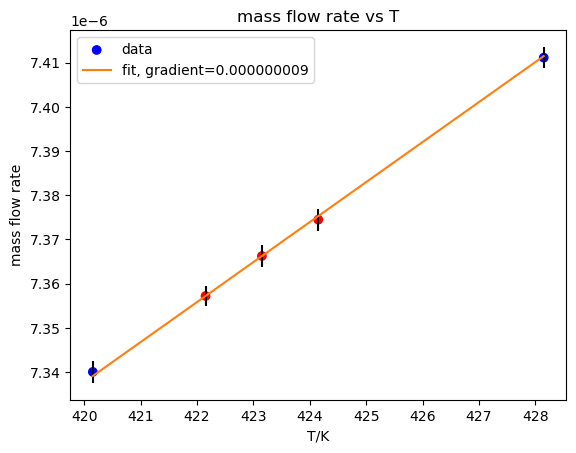

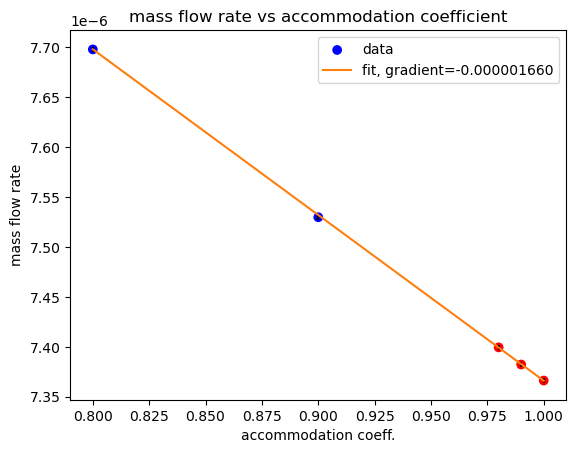

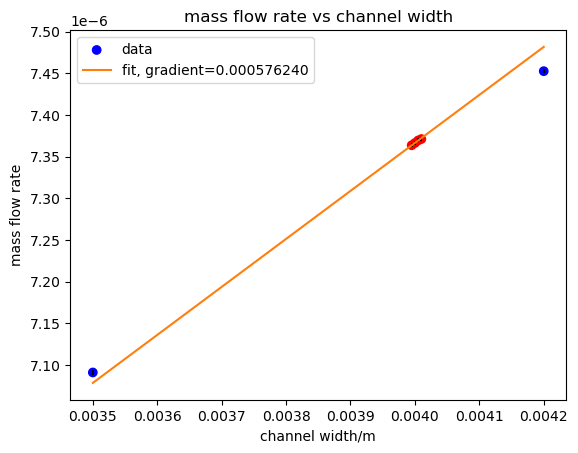

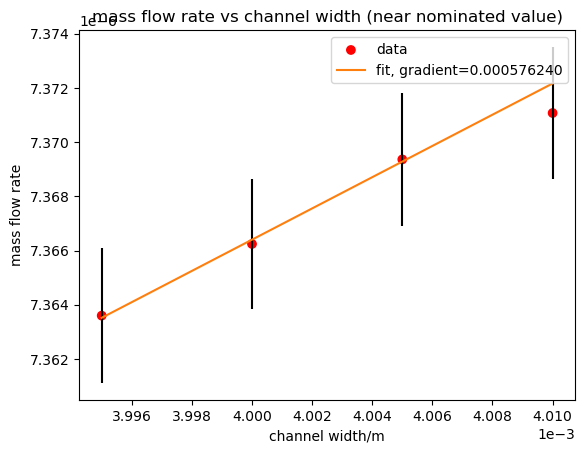

In [69]:
from scipy.optimize import curve_fit

#define straight line
def f(x, A, B):
    return A*x + B

#define colormap
colormap = np.array(['b','r'])


#plot scatter plots
#varying T
T = np.array([420.15, 422.15, 423.15, 424.15, 428.15])
ind_T = [7, 6, 12, 13, 2]
mfr_T = mfr_mu[ind_T]
std_T = np.sqrt(mfr_var[ind_T]/dim)
cat_T = np.array([0, 1, 1, 1, 0])

#fit
popt, pcov = curve_fit(f, T[1:3], mfr_T[1:3])
dQ_dT = popt[0]

plt.figure(1)
plt.scatter(T, mfr_T, c=colormap[cat_T], label='data')
plt.errorbar(T, mfr_T, yerr=std_T, fmt='none', color='k')
plt.plot(T, popt[0]*T+popt[1], 'tab:orange', label='fit, gradient={0:.9f}'.format(popt[0]))
plt.title('mass flow rate vs T')
plt.xlabel('T/K')
plt.ylabel('mass flow rate')
plt.legend()

#varying accommodation coefficient
alpha = np.array([0.8, 0.9, 0.98, 0.99, 1])
ind_a = [1, 10, 3, 5, 12]
mfr_a = mfr_mu[ind_a]
std_a = np.sqrt(mfr_var[ind_a]/dim)
cat_a = np.array([0, 0, 1, 1, 1])

#fit
popt, pcov = curve_fit(f, alpha[2:], mfr_a[2:])
dQ_da = popt[0]

plt.figure(2)
plt.scatter(alpha, mfr_a, c=colormap[cat_a], label='data')
plt.errorbar(alpha, mfr_a, yerr=std_a, fmt='none', color='k')
plt.plot(alpha, popt[0]*alpha+popt[1], 'tab:orange', label='fit, gradient={0:.9f}'.format(popt[0]))
plt.title('mass flow rate vs accommodation coefficient')
plt.xlabel('accommodation coeff.')
plt.ylabel('mass flow rate')
plt.legend()

#varying channel width
h = np.array([0.350, 0.3995, 0.400, 0.4005, 0.401, 0.42])*1e-2
ind_h = [11, 8, 12, 0, 4, 9]
mfr_h = mfr_mu[ind_h]
std_h = np.sqrt(mfr_var[ind_h]/dim)
cat_h = np.array([0, 1, 1, 1, 1, 0])

#fit
popt, pcov = curve_fit(f, h[1:4], mfr_h[1:4])
dQ_dh = popt[0]

plt.figure(3)
plt.scatter(h, mfr_h, c=colormap[cat_h], label='data')
plt.errorbar(h, mfr_h, yerr=std_h, fmt='none', color='k')
plt.plot(h, popt[0]*h+popt[1], 'tab:orange', label='fit, gradient={0:.9f}'.format(popt[0]))
plt.title('mass flow rate vs channel width')
plt.xlabel('channel width/m')
plt.ylabel('mass flow rate')
plt.legend()

plt.figure(33)
plt.scatter(h[1:5], mfr_h[1:5], c=colormap[cat_h[1:5]], label='data')
plt.errorbar(h[1:5], mfr_h[1:5], yerr=std_h[1:5], fmt='none', color='k')
plt.plot(h[1:5], popt[0]*h[1:5]+popt[1], 'tab:orange', label='fit, gradient={0:.9f}'.format(popt[0]))
plt.title('mass flow rate vs channel width (near nominated value)')
plt.xlabel('channel width/m')
plt.ylabel('mass flow rate')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()


plt.show()

### Standard error from time series

Plot of standard deviations for the time series in different variables to convince ourselves on independence between mass flow rate values at different times (should show no tangible trend).

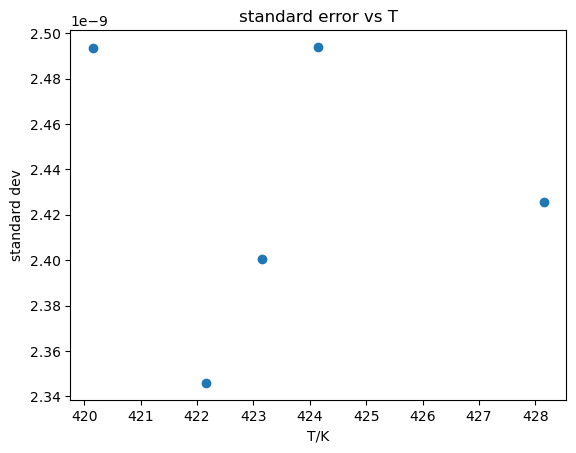

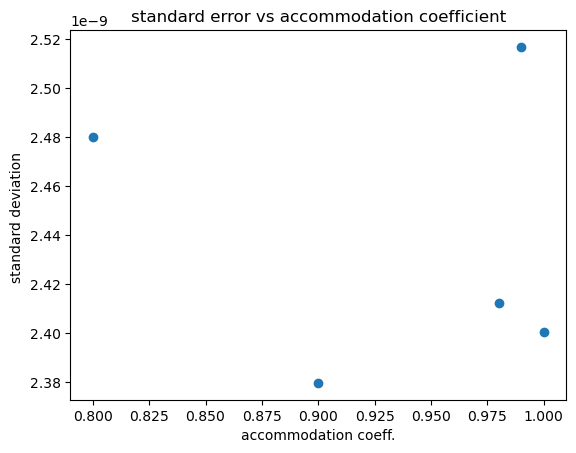

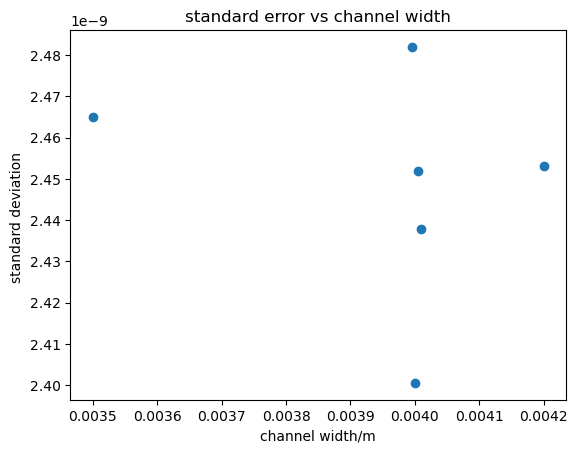

In [67]:
#plot standard errors as a function of parameters
plt.figure(4)
plt.scatter(T, std_T)
plt.title('standard error vs T')
plt.xlabel('T/K')
plt.ylabel('standard dev')

plt.figure(5)
plt.scatter(alpha, std_a)
plt.title('standard error vs accommodation coefficient')
plt.xlabel('accommodation coeff.')
plt.ylabel('standard deviation ')

plt.figure(6)
plt.scatter(h, std_h)
plt.title('standard error vs channel width')
plt.xlabel('channel width/m')
plt.ylabel('standard deviation ')


plt.show()

### First-order sensitivity analysis

The actual UQ part. Calculate the estimated uncertainty $\sigma_p$ ($p$ for _parameter_) due to distribution of values in the input space

\begin{equation}
            \sigma_p^2 = \left(\frac{\partial Q}{\partial \mathbf{x}}\right)^T_{\mathbf{x}=\mathbf{x}_0} \cdot\boldsymbol{\Sigma} \cdot \left(\frac{\partial Q}{\partial \mathbf{x}}\right)_{\mathbf{x}=\mathbf{x}_0}
\end{equation},

where $\boldsymbol{\Sigma}$ is the covariance matrix (which we assume to be diagonal). The bold letters indicate vectors, i.e.
\begin{equation}
\left(\frac{\partial Q}{\partial \mathbf{x}}\right)_{\mathbf{x}=\mathbf{x}_0, i} = \left(\frac{\partial Q}{\partial x_i}\right)_{x_i=x_{i}}
\end{equation}
contains the gradient values at the nominal variable values. The inherent noise from the time series $\sigma_s$ ($s$ for _stochastic_) is then added to this by assumption of independence via

\begin{equation}
(\Delta Q)^2 = \sigma_p^2 + \sigma_s^2
\end{equation}

for the final uncertainity estimate in $Q$.

In [68]:
#define covariance matrix via nominal values
T_nom = 423.15              #K
a_nom = 1.0
h_nom = 0.00400             #m

#Define variances to be 1%
s2_T = 0.01*T_nom
s2_a = 0.01*a_nom
s2_h = 0.01*h_nom

#gradient matrix
grad_Q = np.array([dQ_dT, dQ_da, dQ_dh])
cov = np.array([[s2_T, 0, 0],[0, s2_a, 0],[0, 0, s2_h]])

#obtain estimate of standard deviation in mass flow rate
std_Q = np.sqrt(grad_Q.T @ cov @ grad_Q)

print(mfr_nom, '+/-', '(', std_Q, '+', np.sqrt(var_nom/dim), ')')

#print scaled sensitivities
print(T_nom*dQ_dT, a_nom*dQ_da, h_nom*dQ_dh)

7.366243200000001e-06 +/- ( 3.648289351072955e-06 + 2.4005315245921154e-09 )
3.828915089999314e-06 -1.6603379686402717e-06 2.3049600000208596e-06
